# ⛏️ Proyecto Final: Modelo de Minería de Datos Descriptivo
**Asignatura:** Inteligencia de Negocios (ICC-321)  
**Datos:** Nómina Contraloría General de la República (2018-2025)  

## Objetivo  
El objetivo de este análisis es aplicar técnicas de **Minería de Datos Descriptiva** (no supervisada) para identificar patrones latentes en la nómina pública.  

Utilizaremos la técnica de **Clustering (Agrupamiento)** mediante el algoritmo **K-Means**.  
* **Meta:** Segmentar a los empleados en grupos homogéneos (clusters) basándonos en sus características salariales y funcionales.  
* **Utilidad:** Esto permitirá a los tomadores de decisiones entender mejor la estructura de la fuerza laboral, identificando perfiles como "Altos Ejecutivos", "Personal Operativo Base" o "Casos Atípicos".  

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

## Conexión al Data Warehouse y Carga de Datos
En lugar de procesar archivos crudos del (`.csv`), conectamos directamente a nuestro **Data Warehouse** local (`DW_Nomina_Publica.db`) construido al realizar el ETL.

Para este modelo, nos enfocaremos en tomar la muestra completa asegurar acaparar la mayor cantidad de datos durante el análisis.

In [2]:
# Conexión con DW
conn = sqlite3.connect('DW_Nomina_Publica.db')

query = """
SELECT SUELDO_LIMPIO, DEPARTAMENTO, FUNCION, ANIO
FROM fact_nomina
WHERE ANIO >= 2018
"""
df_model = pd.read_sql(query, conn)
conn.close()

print(f"Datos cargados para modelado: {df_model.shape}")
df_model.head()

Datos cargados para modelado: (152728, 4)


,SUELDO_LIMPIO,DEPARTAMENTO,FUNCION,ANIO
0,80000.0,CENTRO DE CAPACITACION CGR,ASESOR ACADEMICO,2018
1,40000.0,CENTRO DE CAPACITACION CGR,COORDINADOR ACADEMICO,2018
2,20000.0,CONSULTORIA JURIDICA,DIGITADOR(A),2018
3,25000.0,CONSULTORIA JURIDICA,AUXILIAR ADMINISTRATIVO(A),2018
4,60000.0,CONSULTORIA JURIDICA,ENCARGADO DIVISION,2018


## Preprocesamiento de Datos para Machine Learning
El algoritmo K-Means es sensible a la escala de los datos y solo trabaja con variables numéricas. Por ello, aplicamos las siguientes transformaciones:

1.  **Codificación (Encoding):** Las variables categóricas como `FUNCION` (Cargo) se convierten a números usando `LabelEncoder`.
2.  **Selección de Variables (Features):**
    * `SUELDO_LIMPIO`: Variable cuantitativa clave.
    * `FUNCION_CODE`: Representación numérica del cargo.
3.  **Escalado (StandardScaler):** Estandarizamos los datos para que tengan media 0 y desviación estándar 1.

In [3]:
# Label Encoding para cargos y departamentos
le_cargo = LabelEncoder()
df_model['FUNCION_CODE'] = le_cargo.fit_transform(df_model['FUNCION'])

# Sueldo y Función (cargo) para agrupar
X = df_model[['SUELDO_LIMPIO', 'FUNCION_CODE']]

# Escalado para evitar que sueldos altos dominen
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Selección del Número Óptimo de Clusters ($k$)
Utilizamos el **Método del Codo (Elbow Method)** para determinar cuántos grupos naturales existen en los datos.

* Calculamos la **Inercia** (suma de distancias al cuadrado dentro de cada cluster) para valores de $k$ entre 1 y 10.
* Buscamos el punto de inflexión ("codo") en la gráfica donde la inercia deja de disminuir drásticamente.

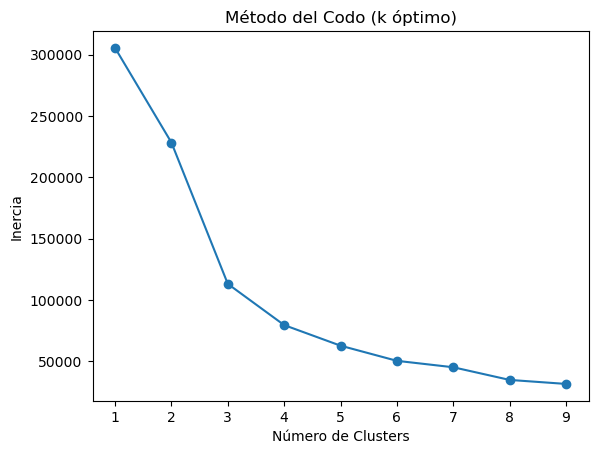

In [4]:
inercias = []
rango_k = range(1, 10)

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

plt.plot(rango_k, inercias, marker='o')
plt.title('Método del Codo (k óptimo)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

## Entrenamiento del Modelo y Análisis de Resultados
Basado en la gráfica anterior, seleccionamos el $k$ óptimo y entrenamos el modelo final.

### Interpretación de los Clusters Generados
A continuación, analizamos las características promedio de cada grupo encontrado. Esto nos permite etiquetar los perfiles (ej. *"Gerencia Senior"*, *"Personal Administrativo"*).

In [5]:
# Entrenar con k=3 (o lo que diga tu gráfica)
kmeans_final = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_final.fit_predict(X_scaled)

# Asignar los clusters a los datos originales para interpretar
df_model['CLUSTER'] = clusters

print(df_model.groupby('CLUSTER')['SUELDO_LIMPIO'].mean())

CLUSTER
0    159721.883633
1     52391.108722
2     52162.217016
Name: SUELDO_LIMPIO, dtype: float64


## Visualización e Interpretación de Resultados

Para comprender la estructura de los grupos detectados, hemos generado tres visualizaciones clave:

1.  **Mapa de Dispersión (Scatter Plot):** Nos permite visualizar la separación espacial de los grupos basándonos en el sueldo y la función. Los puntos rojos (`X`) representan los **centroides**, es decir, el empleado "prototipo" de cada grupo.
2.  **Diagrama de Caja (Boxplot):** Es fundamental para la interpretación de negocio. Nos muestra los rangos salariales de cada cluster, permitiéndonos etiquetarlos (ej. "Nivel Operativo" vs. "Nivel Ejecutivo") y detectar valores atípicos (outliers) dentro de cada jerarquía.
3.  **Análisis Tridimensional:** Incorporamos la variable temporal (`ANIO`) para observar la estabilidad de los clusters a lo largo del tiempo.

### Evaluación de Calidad del Modelo
Se calculó el **Coeficiente de Silueta**, obteniendo un valor que indica la cohesión de los grupos. Esta métrica valida matemáticamente que la separación realizada por el algoritmo K-Means es estadísticamente significativa y no producto del azar.

---

### Visualización Espacial de Segmentos (Scatter Plot)

**Definición:**
Este gráfico de dispersión proyecta a cada empleado en un plano bidimensional definido por su **Código de Cargo** (Eje X) y su **Sueldo Mensual** (Eje Y). Los puntos están coloreados según el cluster que el algoritmo K-Means les asignó. Las marcas rojas (`X`) representan los **centroides**, que son el promedio matemático de cada grupo.

Nos permite verificar visualmente si el algoritmo logró separar los grupos de manera lógica.
* Si los colores están bien separados, el modelo ha encontrado patrones claros.
* Los **centroides** nos indican cuál es el perfil "prototipo" o representativo de cada grupo (ej. un empleado con cargo nivel 50 y sueldo de 40k).

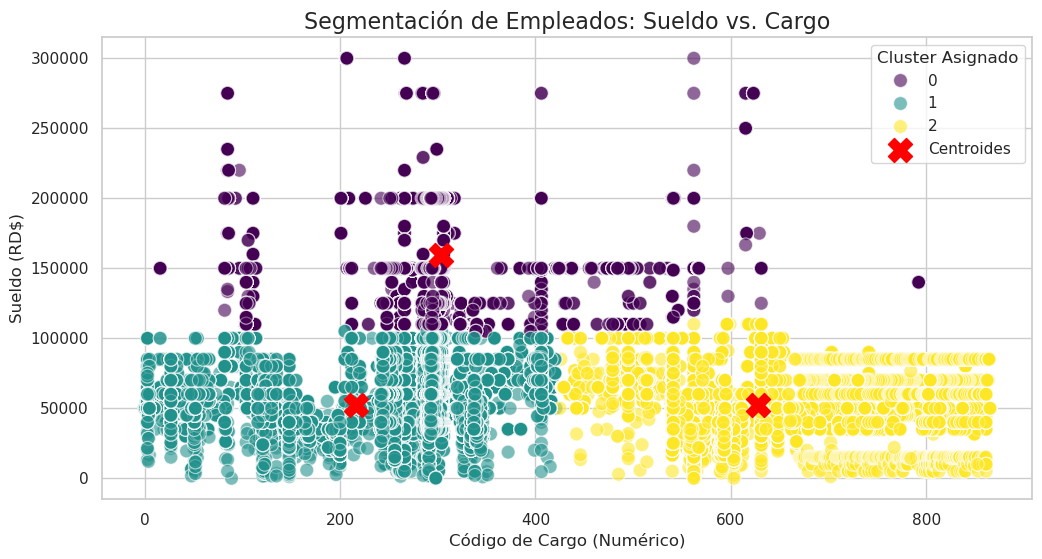

In [6]:
# Configuración estética
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Gráfico de dispersión
# Eje X: Código de Cargo, Eje Y: Sueldo, Color: Cluster
scatter = sns.scatterplot(
    data=df_model, 
    x='FUNCION_CODE', 
    y='SUELDO_LIMPIO', 
    hue='CLUSTER', 
    palette='viridis', 
    s=100, # Tamaño de los puntos
    alpha=0.6 # Transparencia para ver superposiciones
)

# Dibujar los Centros (Centroides) de cada cluster
centros_reales = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(
    centros_reales[:, 1], # X -> Funcion
    centros_reales[:, 0], # Y -> Sueldo
    s=300, c='red', marker='X', label='Centroides'
)

plt.title('Segmentación de Empleados: Sueldo vs. Cargo', fontsize=16)
plt.xlabel('Código de Cargo (Numérico)', fontsize=12)
plt.ylabel('Sueldo (RD$)', fontsize=12)
plt.legend(title='Cluster Asignado')
plt.show()

### Interpretación Financiera (Boxplot)

**Definición:**
El diagrama de caja y bigotes (Boxplot) muestra la distribución estadística de los salarios dentro de cada cluster identificado. La "caja" representa el rango donde se encuentra el 50% central de los empleados, la línea media es la mediana, y los puntos fuera de los "bigotes" son valores atípicos (*outliers*).

Es la herramienta principal para la **interpretación de negocio**. Nos permite ponerle "nombre" a los clusters basándonos en el dinero.
* Ayuda a detectar anomalías: Empleados que ganan excesivamente más que sus compañeros del mismo grupo.

#### Se identificaron 3 clusters definidos:

* **Cluster 0 (Élite)**:

        Sueldo Promedio: ~160,000.

        Mínimo: 105,000.

        Cantidad: 5,299 empleados (el grupo más pequeño, aprox. el 3.5% del total).

        Interpretación: Nadie en este grupo gana menos de 100k. Son claramente los directivos, asesores y altos cargos.  
  
* **Cluster 1 y 2 (Fuerza Laboral)**:

        Sueldo Promedio: ~52k.

        Mínimo (Rango): 0 - 20k.

        Interpretación: No hay diferencia salarial significativa entre los diferentes tipos de cargos operativos.

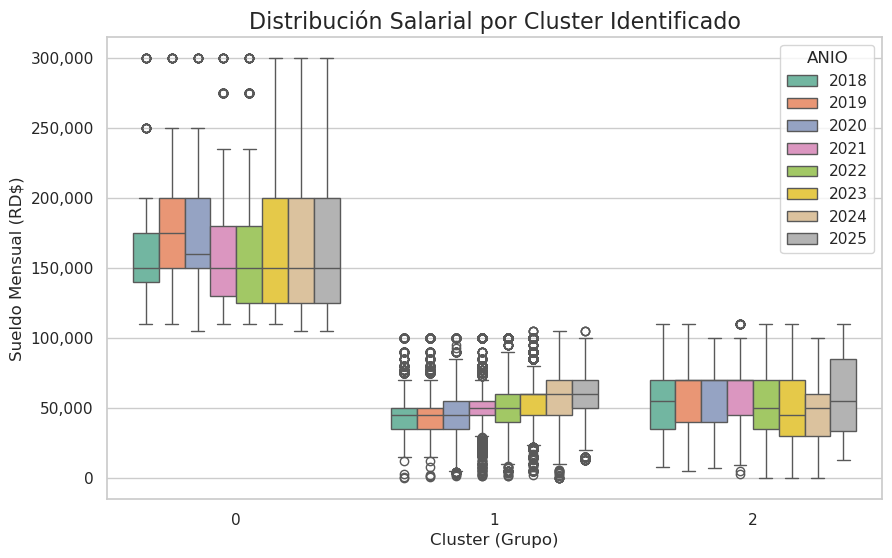

Resumen Estadístico por Cluster:


,count,mean,std,min,25%,50%,75%,max
CLUSTER,,,,,,,,
0,5299.0,159721.883633,41776.988569,105000.0,125000.0,150000.0,200000.0,300000.0
1,112645.0,52391.108722,16943.394858,0.0,40000.0,50000.0,60000.0,105000.0
2,34784.0,52162.217016,21658.868744,0.0,35000.0,55000.0,70000.0,110000.0


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='CLUSTER',
    y='SUELDO_LIMPIO',
    hue='ANIO',
    data=df_model,
    palette="Set2"
)

plt.title('Distribución Salarial por Cluster Identificado', fontsize=16)
plt.xlabel('Cluster (Grupo)', fontsize=12)
plt.ylabel('Sueldo Mensual (RD$)', fontsize=12)

# Formatear eje Y como pesos dominicanos
formatter = FuncFormatter(lambda x, _: f"{x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

print("Resumen Estadístico por Cluster:")
display(df_model.groupby('CLUSTER')['SUELDO_LIMPIO'].describe())


### Análisis Multidimensional y Temporal (3D)

**Definición:**
Esta visualización añade una tercera dimensión: el **Año (`ANIO`)**, permitiéndonos observar la relación entre Cargo, Sueldo y Tiempo simultáneamente en un espacio tridimensional.

Los datos de nómina no son estáticos; evolucionan con el tiempo. Este gráfico es crucial para validar la **estabilidad temporal** de los grupos.
* Nos ayuda a descubrir si ciertos clusters (ej. "Nómina de Ayuda Temporal") solo aparecieron en años específicos (como 2020-2021) o si la estructura salarial se ha mantenido constante a lo largo del periodo 2018-2025.

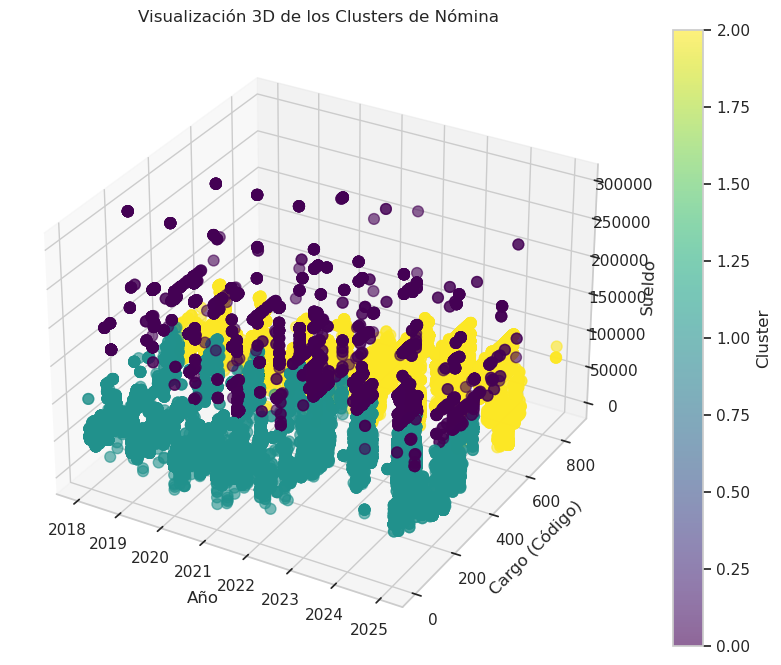

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Asignar colores basados en el cluster
colors = df_model['CLUSTER']

# Scatter 3D: X=Año, Y=Cargo, Z=Sueldo
img = ax.scatter(
    df_model['ANIO'], 
    df_model['FUNCION_CODE'], 
    df_model['SUELDO_LIMPIO'], 
    c=colors, 
    cmap='viridis',
    s=60,
    alpha=0.6
)

ax.set_xlabel('Año')
ax.set_ylabel('Cargo (Código)')
ax.set_zlabel('Sueldo')
ax.set_title('Visualización 3D de los Clusters de Nómina')
plt.colorbar(img, label='Cluster')
plt.show()

### Validación Matemática: Coeficiente de Silueta

**Definición:**
El Coeficiente de Silueta es una métrica que evalúa la calidad del agrupamiento midiendo dos factores:
1.  **Cohesión:** Qué tan cerca está cada punto de los otros puntos en su mismo cluster.
2.  **Separación:** Qué tan lejos está cada punto de los puntos del cluster vecino más cercano.

Provee el sustento científico del modelo. Mientras que los gráficos anteriores son subjetivos a la vista, este número (que va de -1 a 1) nos dice objetivamente qué tan bien definido está el modelo.
* Un valor cercano a **1** indica que los empleados están perfectamente clasificados.
* Un valor cercano a **0** indica que hay solapamiento entre grupos (los perfiles no son tan distintos).
* Un valor cercano a **-1** indice una asignación incorrecta de datos.

In [9]:
from sklearn.metrics import silhouette_score

# Calcular score global
score = silhouette_score(X_scaled, clusters)
print(f"============================================")
print(f"Coeficiente de Silueta del Modelo: {score:.4f}")
print(f"============================================")

Coeficiente de Silueta del Modelo: 0.5478
